In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
import re

In [7]:
def create_jpg(filename):
    """
    This function takes in a string filename and outputs a jpg
    """
    
    hdul = fits.open(filename)
    
    hdr0 = hdul[0].header
    
    ext = np.arange(1, 9) # extension numbers 1 - 8
    
    binning = hdr0['BINNING'].split(',')
    
    precol = int(hdr0['PRECOL'])     // int(binning[0])
    postpix = int(hdr0['POSTPIX'])   // int(binning[0])
    preline = int(hdr0['PRELINE'])   // int(binning[1])
    postline = int(hdr0['POSTLINE']) // int(binning[1])
    
    zscale = ZScaleInterval()
    vmin = None
    vmax = None
    
    alldata = []
    for i in ext:
        data = hdul[i].data
        
        height, width = hdul[i].shape
        
        # calculate bias from overscan region
        # bias subtraction
        x1 = 0
        x2 = height
        y1 = width - postpix + 1
        y2 = width
        
        bias = np.median(data[x1:x2, y1:y2], axis = 1)
        bias = np.array(bias, dtype = np.int64)
        data = data - bias[:, None]
        
        # min / max of each extension
        # sample box is 90% of full area
        x1 = int(preline            + (height * 0.10))
        x2 = int(height  - postline - (height * 0.10))
        y1 = int(precol             + (width * 0.10))
        y2 = int(width - postpix    - (width * 0.10))
        tmp_vmin, tmp_vmax = zscale.get_limits(data[x1:x2, y1:y2])
        if vmin == None or tmp_vmin < vmin: vmin = tmp_vmin
        if vmax == None or tmp_vmax < vmax: vmax = tmp_vmax
        if vmin < 0: vmin = 0
            
        # remove overscan region
        data = data[:, precol: width-postpix]
        
        # append all 8 biased arrays into a list
        alldata.append(data)
    
    # creating the rows of the mosaic
    r0 = np.concatenate(alldata[:4], axis=1)
    r0 = np.flipud(r0)

    r1 = []
    for arr in alldata[4:]:
        arr = np.fliplr(arr)
        r1.append(arr)
    r1 = np.concatenate(r1, axis=1)
    
    # stacking the rows 
    fulldata = np.concatenate((r1, r0), axis=0)
    fulldata = np.rot90(fulldata)

    # creating jpg
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0,0,1,1])
    plt.axis('off')
    plt.imshow(fulldata, cmap='gray', norm=norm)
    plt.show()

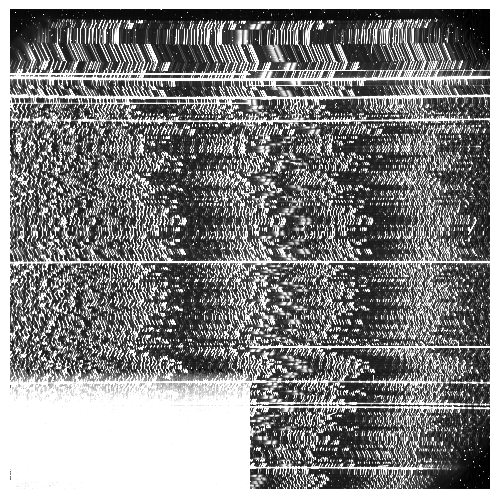

In [8]:
og = create_jpg('DE.20210602.22392.fits')

In [4]:
#test1 = create_jpg('DE.20200610.22314.fits')